In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf

In [2]:
import kagglehub

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Ruta en cache:", path)

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Ruta en cache: /kaggle/input/dog-and-cat-classification-dataset


In [3]:
base_path = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
cats_dir = base_path + '/Cat'
dogs_dir = base_path + '/Dog'

dog_files = list(Path(dogs_dir).glob("*.jpg"))
cats_files = list(Path(cats_dir).glob("*.jpg"))

In [4]:
dogs = pd.DataFrame({"filePath": dog_files, "label": 1})
print(len(dogs))

cats = pd.DataFrame({"filePath": cats_files, "label": 0})
print(len(cats))

12499
12499


In [5]:
df = pd.concat([cats, dogs], ignore_index=True)
df.describe()

,label
count,24998.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


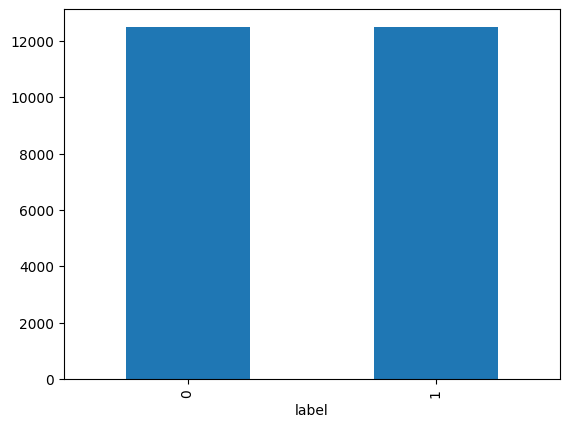

In [6]:
df['label'].value_counts().plot(kind="bar")
plt.show()

In [7]:
from PIL import Image, ImageFile

def is_ok(path):
  try:
    with Image.open(path) as im:
      im.verify()
    return True
  except:
    return False

df = df[df['filePath'].apply(is_ok)].reset_index(drop=True)

df.describe()

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


,label
count,24998.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [8]:
def has_valid_channels(path):
    try:
        with Image.open(path) as im:
            im.load()
            ch = len(im.getbands())
            return ch in (1, 3, 4)
    except:
        return False

df = df[df['filePath'].apply(has_valid_channels)].reset_index(drop=True)
print("Imágenes tras filtrar canales inválidos:", len(df))
print(df['label'].value_counts())


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Imágenes tras filtrar canales inválidos: 24998
label
0    12499
1    12499
Name: count, dtype: int64


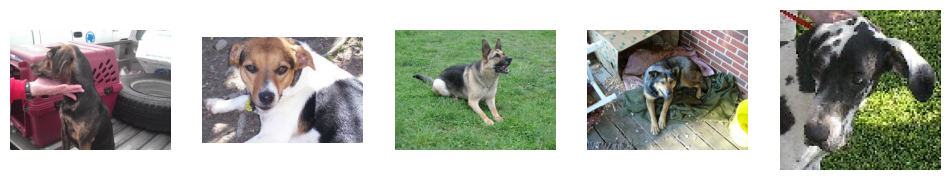

In [9]:
sample_dogs = dogs.sample(5, random_state=1)

plt.figure(figsize=(12, 4))
for i, path in enumerate(sample_dogs['filePath'], 1):
    img = Image.open(path)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.axis("off")
plt.show()

Ya hemos comporbado que el dataset esta balanceado, como son las fotos tanto de los gatos como de los perros y hemos eliminado las fotos que estaban rotas.

# Preparacion de Training Data:

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=43)

In [11]:
IMG_SIZE = (180,180)
AUTOTUNE = tf.data.AUTOTUNE

def _load_rgb(path_bytes):
    path = path_bytes.numpy().decode("utf-8")
    with Image.open(path) as im:
        im = im.convert("RGB")
        arr = np.array(im, dtype=np.float32)
    return arr

def preprocess(filePath, label):
    img = tf.py_function(func=_load_rgb, inp=[filePath], Tout=tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, tf.cast(label, tf.int32)

def make_ds(frame, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices(
      (frame['filePath'].astype(str).values, frame['label'].values)
  ).map(preprocess, num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000, seed=43, reshuffle_each_iteration=True)
  return ds.batch(32).cache().prefetch(AUTOTUNE)

In [12]:
train_ds = make_ds(train_df, shuffle=True)
test_ds  = make_ds(test_df, shuffle=False)

# Creating the CNN

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
model = Sequential()

#input
model.add(Conv2D(32,(3,3), activation='relu', input_shape=IMG_SIZE+(3,)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#hidden
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#output
model.add(Dense(2, activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,295,618 (50.72 MB)

 Trainable params: 13,294,530 (50.71 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [15]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
386/625 ━━━━━━━━━━━━━━━━━━━━ 39s 164ms/step - accuracy: 0.6287 - loss: 0.9275

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 223ms/step - accuracy: 0.6454 - loss: 0.8319 - val_accuracy: 0.6404 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.7689 - loss: 0.4833 - val_accuracy: 0.6930 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8082 - loss: 0.4159 - val_accuracy: 0.7390 - val_loss: 0.5583 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8602 - loss: 0.3240 - val_accuracy: 0.7650 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8991 - loss: 0.2440 - val_accuracy: 0.7768 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9405 - loss: 0.1538 - val_accuracy: 0.8228 - val_loss: 0.5248 - learning_rate: 5.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9747 - loss: 

# Graficar resultados

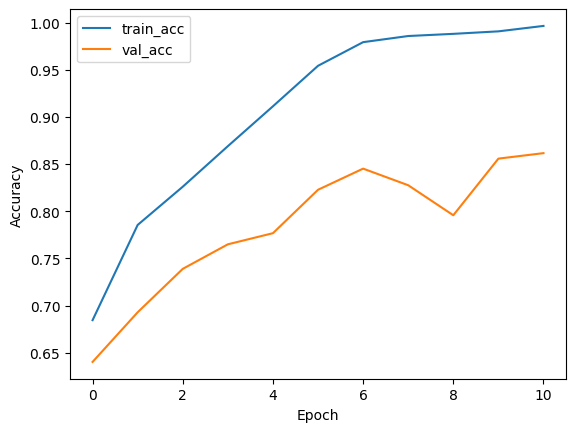

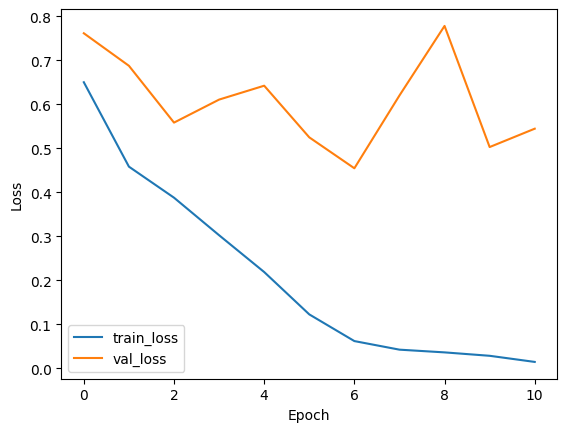

In [18]:
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

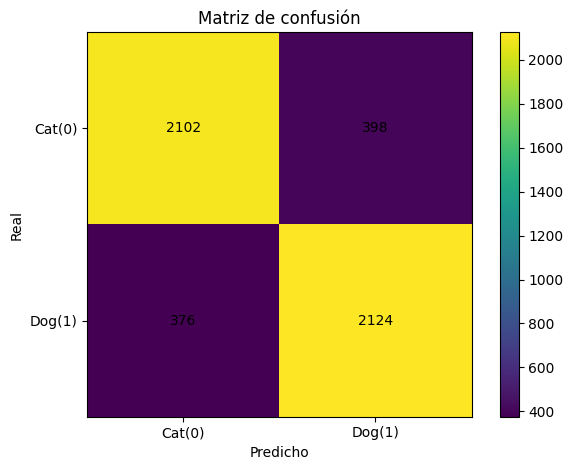

              precision    recall  f1-score   support

         Cat       0.85      0.84      0.84      2500
         Dog       0.84      0.85      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat(0)','Dog(1)'])
plt.yticks(tick_marks, ['Cat(0)','Dog(1)'])
plt.xlabel('Predicho')
plt.ylabel('Real')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=['Cat','Dog']))

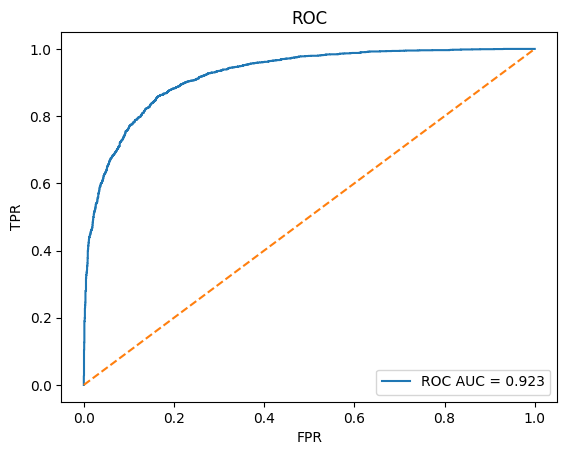

In [22]:
from sklearn.metrics import roc_curve, auc

pos_scores = y_prob[:,1]
fpr, tpr, _ = roc_curve(y_true, pos_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()


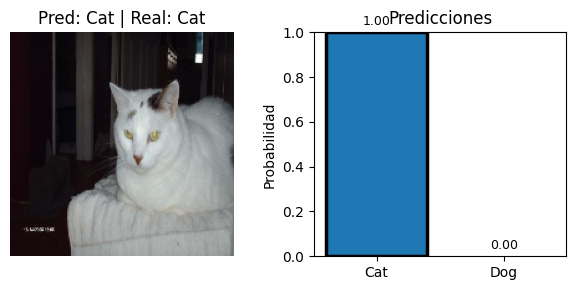

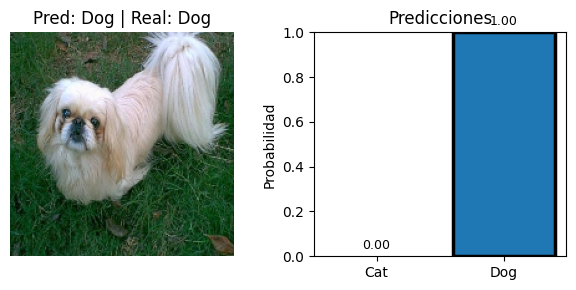

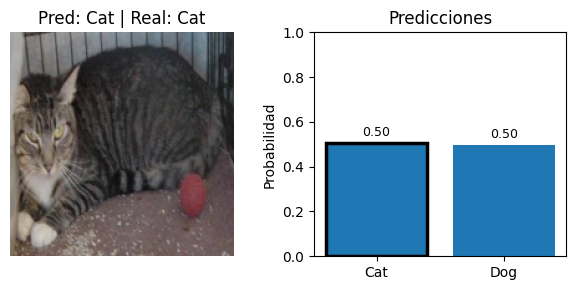

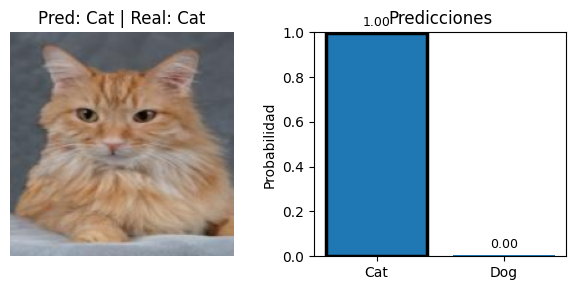

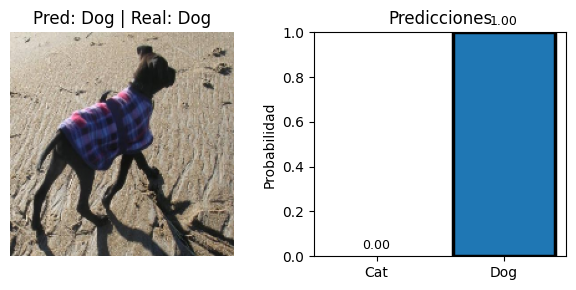

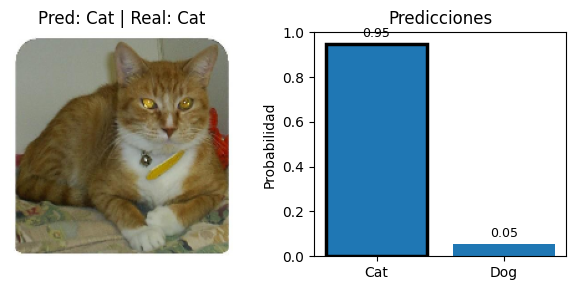

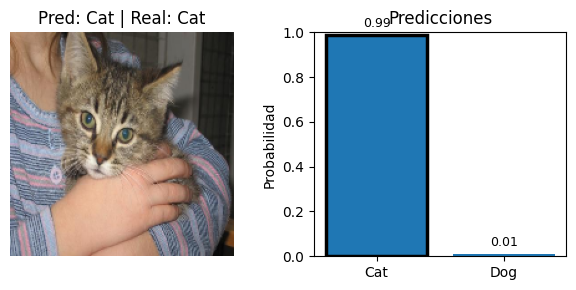

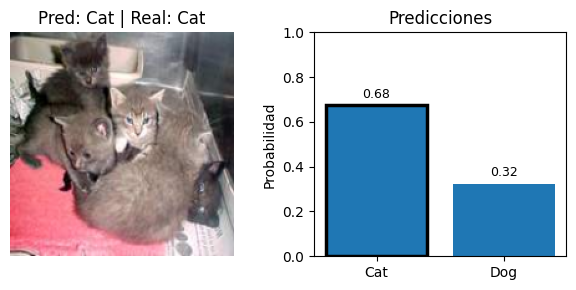

In [24]:
sample_images = []
sample_labels = []
for bx, by in test_ds.take(4):
    sample_images.append(bx.numpy())
    sample_labels.append(by.numpy())
sample_images = np.concatenate(sample_images, axis=0)
sample_labels = np.concatenate(sample_labels, axis=0)

sample_probs = model.predict(sample_images, verbose=0)
sample_preds = sample_probs.argmax(axis=1)

class_names = ['Cat', 'Dog']

def plot_image_with_probs(img, probs, true_label=None, pred_label=None, class_names=('Cat','Dog')):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    axes[0].imshow(img)
    axes[0].axis('off')
    ttl_left = []
    if pred_label is not None:
        ttl_left.append(f"Pred: {class_names[pred_label]}")
    if true_label is not None:
        ttl_left.append(f"Real: {class_names[true_label]}")
    axes[0].set_title(" | ".join(ttl_left) if ttl_left else "Imagen")

    axes[1].bar(range(len(probs)), probs)
    axes[1].set_xticks(range(len(probs)))
    axes[1].set_xticklabels(class_names)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel("Probabilidad")
    axes[1].set_title("Predicciones")

    if pred_label is not None:
        axes[1].patches[pred_label].set_linewidth(2.5)
        axes[1].patches[pred_label].set_edgecolor('black')

    for i, p in enumerate(axes[1].patches):
        prob_val = probs[i]
        axes[1].text(p.get_x() + p.get_width()/2.0, prob_val + 0.02, f"{prob_val:.2f}",
                     ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

n = 8
for i in range(min(n, len(sample_images))):
    plot_image_with_probs(
        img=sample_images[i],
        probs=sample_probs[i],
        true_label=int(sample_labels[i]),
        pred_label=int(sample_preds[i]),
        class_names=class_names
    )